In [0]:
# # Generic restart command
dbutils.library.restartPython()

In [0]:
!free -m

               total        used        free      shared  buff/cache   available
Mem:          249480       57700      191499           0         279      191779
Swap:          10239           0       10239


In [0]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import squareform, pdist
from scipy.cluster.hierarchy import dendrogram , linkage , fcluster

import matplotlib.pyplot as plt 
import seaborn as sns

from pyspark.sql.types import FloatType
from pyspark.sql.functions import regexp_replace, col, when, count

from pyspark.sql import functions as F
from pyspark.sql.types import NumericType, FloatType

from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

# Define target catalog for SQL based on the environment variable
trgt_cat = os.environ.get('trgt_cat')

# Use appropriate Spark catalog based on the target category
spark.sql('USE CATALOG prod;')

DataFrame[]

#### Load the dataset

In [0]:
# 1. Load correct table
df_spark = spark.sql("""
    SELECT * 
    FROM dev.clncl_ds.herald_eda_train_wide_cleaned
""")

In [0]:
row_count = df_spark.count()
print(f"Number of rows: {row_count}")

Number of rows: 4510355


In [0]:
num_cols = len(df_spark.columns)
print(f"Number of columns: {num_cols}")

Number of columns: 175


In [0]:
df_spark.printSchema()

root
 |-- PAT_ID: string (nullable = true)
 |-- END_DTTM: date (nullable = true)
 |-- FUTURE_CRC_EVENT: integer (nullable = true)
 |-- IS_FEMALE: integer (nullable = true)
 |-- IS_MARRIED_PARTNER: integer (nullable = true)
 |-- RACE_CAUCASIAN: integer (nullable = true)
 |-- RACE_BLACK_OR_AFRICAN_AMERICAN: integer (nullable = true)
 |-- RACE_HISPANIC: integer (nullable = true)
 |-- RACE_ASIAN: integer (nullable = true)
 |-- RACE_OTHER: integer (nullable = true)
 |-- HAS_PCP_AT_END: integer (nullable = true)
 |-- V_BMI_CHANGE_6M: double (nullable = true)
 |-- V_BP_SYSTOLIC: double (nullable = true)
 |-- V_CACHEXIA_RISK_SCORE: integer (nullable = true)
 |-- V_FEVER_FLAG: integer (nullable = true)
 |-- V_HYPERTENSION_FLAG: integer (nullable = true)
 |-- V_MAX_WEIGHT_LOSS_PCT_60D: double (nullable = true)
 |-- V_OBESE_FLAG: integer (nullable = true)
 |-- V_PULSE: double (nullable = true)
 |-- V_PULSE_PRESSURE: double (nullable = true)
 |-- V_RAPID_WEIGHT_LOSS_FLAG: integer (nullable = true)

In [0]:
from pyspark.sql import functions as F
# compute mean
df_spark.agg(
    F.mean("FUTURE_CRC_EVENT").alias("mean_value")
).show()

+--------------------+
|          mean_value|
+--------------------+
|0.001655967213223...|
+--------------------+



In [0]:
print("Converting all numeric columns to float...")

from pyspark.sql.functions import col

# Get all columns except PAT_ID and END_DTTM
numeric_cols = [c for c in df_spark.columns if c not in ['PAT_ID', 'END_DTTM']]

# Cast each numeric column to FloatType
for c in numeric_cols:
    df_spark = df_spark.withColumn(c, col(c).cast('float'))

print(f"Converted {len(numeric_cols)} columns to float")
print("\nData types after conversion:")
display(df_spark.dtypes)

Converting all numeric columns to float...
Converted 173 columns to float

Data types after conversion:


_1,_2
PAT_ID,string
END_DTTM,date
FUTURE_CRC_EVENT,float
IS_FEMALE,float
IS_MARRIED_PARTNER,float
RACE_CAUCASIAN,float
RACE_BLACK_OR_AFRICAN_AMERICAN,float
RACE_HISPANIC,float
RACE_ASIAN,float
RACE_OTHER,float


In [0]:
# Desired overall sample fraction
desired_fraction = 1.0  # For sampling all of the data

# Since the values are only 0 and 1, we can set fractions directly
fractions = {0: desired_fraction, 1: desired_fraction}

# Perform stratified sampling using sampleBy
sampled_df = df_spark.sampleBy('FUTURE_CRC_EVENT', fractions=fractions, seed=217)

# Verify the sampled class distribution
sampled_class_counts = sampled_df.groupBy('FUTURE_CRC_EVENT').count()
sampled_class_counts.show()

# Get the mean
# compute mean
sampled_df.agg(
    F.mean("FUTURE_CRC_EVENT").alias("mean_value")
).show()

# Convert the sampled Spark DataFrame to pandas (if needed)
pandas_df = sampled_df.toPandas()

+----------------+-------+
|FUTURE_CRC_EVENT|  count|
+----------------+-------+
|             1.0|   7469|
|             0.0|4502886|
+----------------+-------+

+--------------------+
|          mean_value|
+--------------------+
|0.001655967213223...|
+--------------------+



In [0]:
pandas_df.shape

(4510355, 175)

In [0]:
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4510355 entries, 0 to 4510354
Columns: 175 entries, PAT_ID to quarters_since_study_start
dtypes: float32(173), object(2)
memory usage: 3.0+ GB


In [0]:
# Set the maximum number of rows to None, which means unlimited
pd.set_option('display.max_rows', None)

In [0]:
pandas_df.sample(5).T

,2724724,3666437,469855,3722672,4129403
PAT_ID,Z7725548,Z1417421,Z6881917,Z9938953,Z7759162
END_DTTM,2024-06-01,2023-09-21,2023-07-20,2024-06-22,2024-08-29
FUTURE_CRC_EVENT,0.0,0.0,0.0,0.0,0.0
IS_FEMALE,1.0,1.0,0.0,1.0,1.0
IS_MARRIED_PARTNER,1.0,0.0,1.0,0.0,0.0
RACE_CAUCASIAN,1.0,1.0,1.0,1.0,1.0
RACE_BLACK_OR_AFRICAN_AMERICAN,0.0,0.0,0.0,0.0,0.0
RACE_HISPANIC,0.0,0.0,0.0,0.0,0.0
RACE_ASIAN,0.0,0.0,0.0,0.0,0.0
RACE_OTHER,0.0,0.0,0.0,0.0,0.0


In [0]:
pandas_df.isnull().sum()/pandas_df.shape[0]

PAT_ID                                  0.000000
END_DTTM                                0.000000
FUTURE_CRC_EVENT                        0.000000
IS_FEMALE                               0.000000
IS_MARRIED_PARTNER                      0.000000
RACE_CAUCASIAN                          0.000000
RACE_BLACK_OR_AFRICAN_AMERICAN          0.000000
RACE_HISPANIC                           0.000000
RACE_ASIAN                              0.000000
RACE_OTHER                              0.000000
HAS_PCP_AT_END                          0.000000
V_BMI_CHANGE_6M                         0.782561
V_BP_SYSTOLIC                           0.153094
V_CACHEXIA_RISK_SCORE                   0.000000
V_FEVER_FLAG                            0.000000
V_HYPERTENSION_FLAG                     0.000000
V_MAX_WEIGHT_LOSS_PCT_60D               0.839352
V_OBESE_FLAG                            0.000000
V_PULSE                                 0.192095
V_PULSE_PRESSURE                        0.153094
V_RAPID_WEIGHT_LOSS_

In [0]:
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4510355 entries, 0 to 4510354
Columns: 175 entries, PAT_ID to quarters_since_study_start
dtypes: float32(173), object(2)
memory usage: 3.0+ GB


In [0]:
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4510355 entries, 0 to 4510354
Columns: 175 entries, PAT_ID to quarters_since_study_start
dtypes: float32(173), object(2)
memory usage: 3.0+ GB


#### Handle missing data that can be imputed with the set values

###### Although we are going to use XGBoost, this correlation process can't have missing data.

In [0]:
# =============================================================================
# COMPREHENSIVE IMPUTATION STRATEGY
# =============================================================================
# Handle missing values based on feature type semantics

import pandas as pd
import numpy as np

# Separate columns
id_cols = ['PAT_ID', 'END_DTTM']
target_col = ['FUTURE_CRC_EVENT']
exclude_cols = id_cols + target_col + ['LABEL_USABLE']
feature_cols = [c for c in pandas_df.columns if c not in exclude_cols]

print(f"Total features to impute: {len(feature_cols)}")
print(f"Total missing values: {pandas_df[feature_cols].isnull().sum().sum():,}")

# Create working copy
X = pandas_df[feature_cols].copy()

# Track imputation by type
imputation_summary = {
    'time_since': [],
    'binary': [],
    'count': [],
    'continuous': []
}

# Impute each feature based on its characteristics
for col in feature_cols:
    n_missing = X[col].isnull().sum()
    
    if n_missing == 0:
        continue
    
    # 1. TIME-SINCE FEATURES (days_since, recency, etc.)
    if 'days_since' in col.lower() or col.endswith('_DAYS') or 'recency' in col.lower():
        max_val = X[col].max()
        fill_val = max_val + 1 if not pd.isna(max_val) else 730
        X[col] = X[col].fillna(fill_val)
        imputation_summary['time_since'].append((col, n_missing, fill_val))
    
    # 2. BINARY FLAGS (only 0 and 1)
    elif len(X[col].dropna().unique()) <= 2 and set(X[col].dropna().unique()).issubset({0, 1}):
        X[col] = X[col].fillna(0)
        imputation_summary['binary'].append((col, n_missing, 0))
    
    # 3. COUNT FEATURES (non-negative integers)
    elif X[col].dtype in ['int64', 'int32'] and (X[col].dropna() >= 0).all():
        X[col] = X[col].fillna(0)
        imputation_summary['count'].append((col, n_missing, 0))
    
    # 4. CONTINUOUS FEATURES (everything else)
    else:
        median_val = X[col].median()
        X[col] = X[col].fillna(median_val)
        imputation_summary['continuous'].append((col, n_missing, median_val))

# Verify no missing values remain
remaining_missing = X.isnull().sum().sum()
assert remaining_missing == 0, f"Still have {remaining_missing} missing values!"

print("\n" + "="*70)
print("IMPUTATION SUMMARY")
print("="*70)

print(f"\nTime-since features: {len(imputation_summary['time_since'])} features")
if imputation_summary['time_since']:
    print("  (Filled with max+1 or 730 = 'never observed')")
    for col, n, val in imputation_summary['time_since'][:3]:
        print(f"    {col}: {n:,} values → {val:.0f}")
    if len(imputation_summary['time_since']) > 3:
        print(f"    ... and {len(imputation_summary['time_since'])-3} more")

print(f"\nBinary features: {len(imputation_summary['binary'])} features")
if imputation_summary['binary']:
    print("  (Filled with 0 = 'flag not present')")
    for col, n, val in imputation_summary['binary'][:3]:
        print(f"    {col}: {n:,} values → {val}")
    if len(imputation_summary['binary']) > 3:
        print(f"    ... and {len(imputation_summary['binary'])-3} more")

print(f"\nCount features: {len(imputation_summary['count'])} features")
if imputation_summary['count']:
    print("  (Filled with 0 = 'no events')")
    for col, n, val in imputation_summary['count'][:3]:
        print(f"    {col}: {n:,} values → {val}")
    if len(imputation_summary['count']) > 3:
        print(f"    ... and {len(imputation_summary['count'])-3} more")

print(f"\nContinuous features: {len(imputation_summary['continuous'])} features")
if imputation_summary['continuous']:
    print("  (Filled with median = 'typical patient')")
    for col, n, val in imputation_summary['continuous'][:3]:
        print(f"    {col}: {n:,} values → {val:.2f}")
    if len(imputation_summary['continuous']) > 3:
        print(f"    ... and {len(imputation_summary['continuous'])-3} more")

print("\n" + "="*70)
print("✓ Imputation complete - ready for correlation analysis")
print("="*70)

# Replace original feature columns with imputed versions
pandas_df[feature_cols] = X

Total features to impute: 172
Total missing values: 101,128,260

IMPUTATION SUMMARY

Time-since features: 0 features

Binary features: 11 features
  (Filled with 0 = 'flag not present')
    LAB_ALBUMIN_DROP_15PCT_FLAG: 1,992,652 values → 0
    LAB_ANEMIA_GRADE: 4,510,355 values → 0
    LAB_AST_ABNORMAL: 1,951,853 values → 0
    ... and 8 more

Count features: 0 features

Continuous features: 22 features
  (Filled with median = 'typical patient')
    V_BMI_CHANGE_6M: 3,529,630 values → 0.00
    V_BP_SYSTOLIC: 690,508 values → 128.00
    V_MAX_WEIGHT_LOSS_PCT_60D: 3,785,776 values → 0.30
    ... and 19 more

✓ Imputation complete - ready for correlation analysis


In [0]:
pandas_df.isnull().sum()/pandas_df.shape[0]

PAT_ID                                  0.0
END_DTTM                                0.0
FUTURE_CRC_EVENT                        0.0
IS_FEMALE                               0.0
IS_MARRIED_PARTNER                      0.0
RACE_CAUCASIAN                          0.0
RACE_BLACK_OR_AFRICAN_AMERICAN          0.0
RACE_HISPANIC                           0.0
RACE_ASIAN                              0.0
RACE_OTHER                              0.0
HAS_PCP_AT_END                          0.0
V_BMI_CHANGE_6M                         0.0
V_BP_SYSTOLIC                           0.0
V_CACHEXIA_RISK_SCORE                   0.0
V_FEVER_FLAG                            0.0
V_HYPERTENSION_FLAG                     0.0
V_MAX_WEIGHT_LOSS_PCT_60D               0.0
V_OBESE_FLAG                            0.0
V_PULSE                                 0.0
V_PULSE_PRESSURE                        0.0
V_RAPID_WEIGHT_LOSS_FLAG                0.0
V_SBP_VARIABILITY_6M                    0.0
V_TACHYCARDIA_FLAG              

#### Hierarchical clustering!!!

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

print("="*70)
print("HIERARCHICAL CLUSTERING OF FEATURES")
print("="*70)

# 1) Isolate features and drop constant columns
exclude_cols = ['PAT_ID', 'END_DTTM', 'FUTURE_CRC_EVENT', 'LABEL_USABLE']
feature_cols = [c for c in pandas_df.columns if c not in exclude_cols]
df = pandas_df[feature_cols].copy()

# Drop constant columns
df = df.loc[:, df.nunique(dropna=True) > 1]
print(f"Features after removing constants: {len(df.columns)}")

# 2) Compute Spearman correlation
corr = df.corr(method='spearman').abs()
dist_matrix = 1 - corr

# 3) Convert to condensed form
condensed = squareform(dist_matrix.values)

# 4) Hierarchical clustering
linked = linkage(condensed, method='average')

HIERARCHICAL CLUSTERING OF FEATURES
Features after removing constants: 170


✓ Clustering complete on 170 features


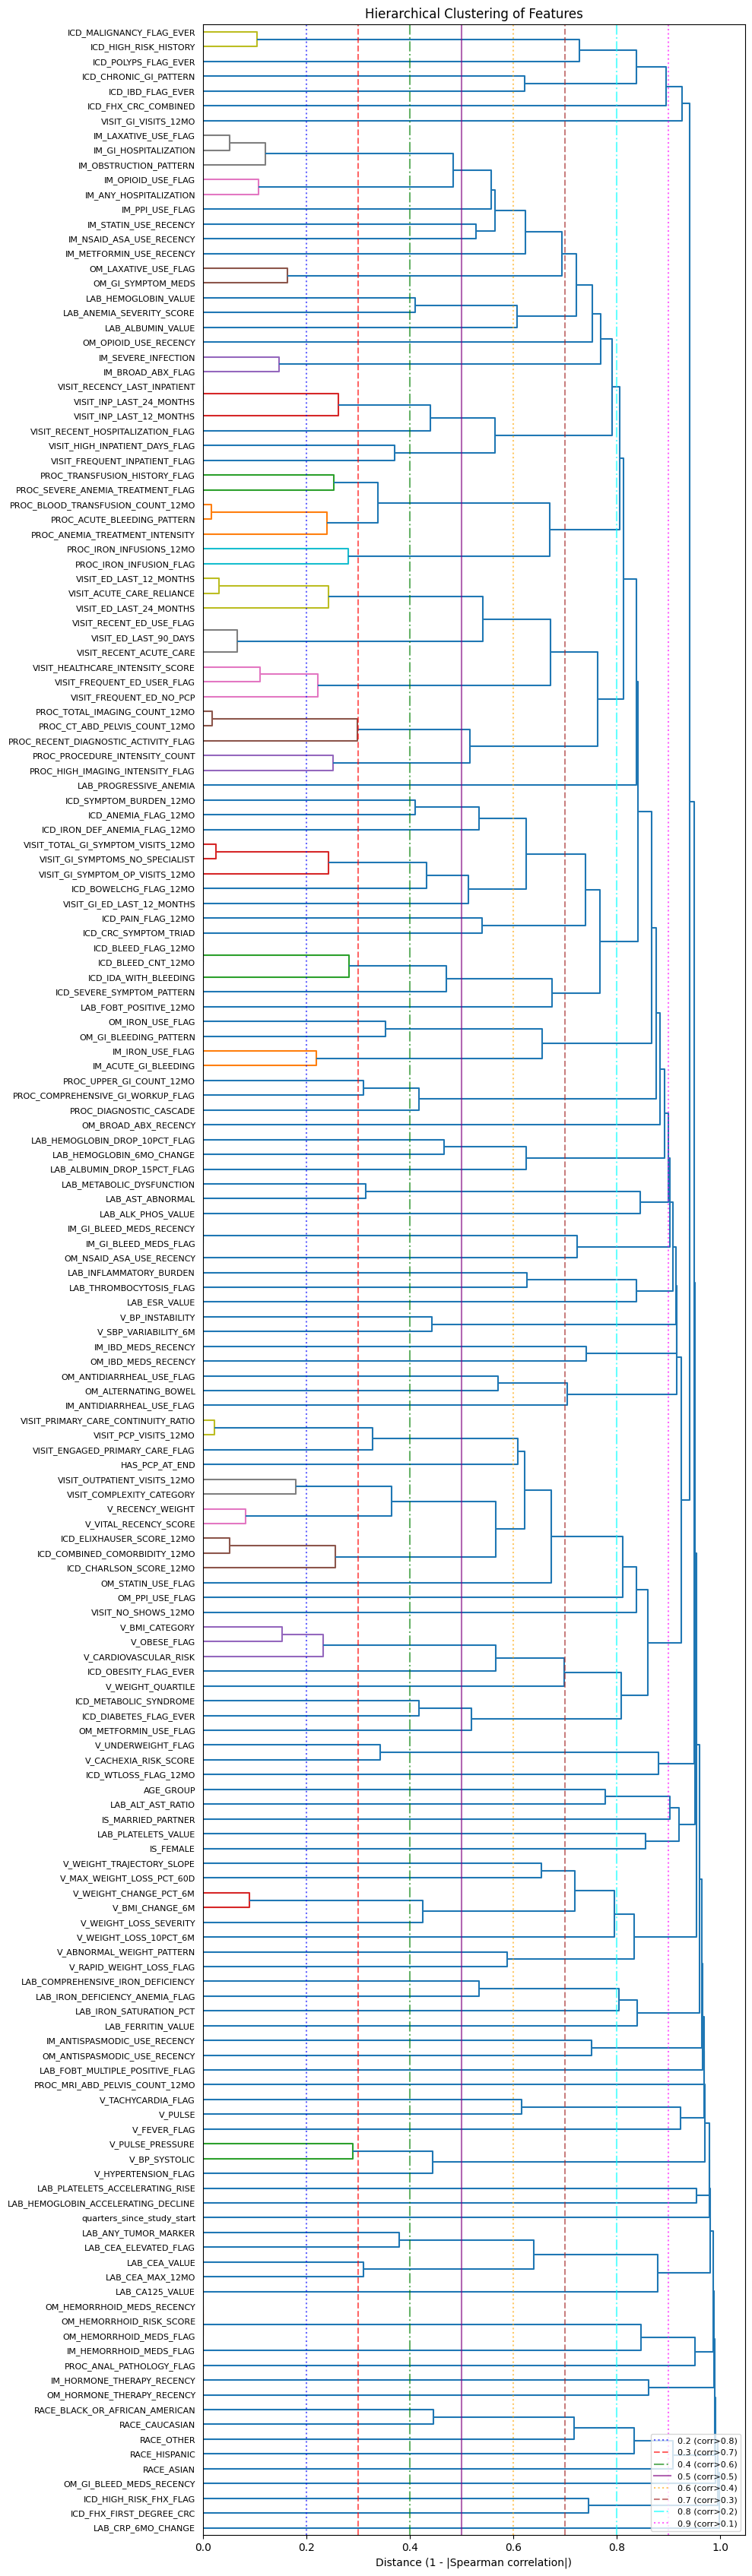


CLUSTER ANALYSIS AT DIFFERENT THRESHOLDS

Threshold 0.2 (correlation > 0.8):
  Total clusters: 146
  Clusters with 2+ features: 21
  Largest cluster: 3 features

Threshold 0.3 (correlation > 0.7):
  Total clusters: 132
  Clusters with 2+ features: 26
  Largest cluster: 3 features

Threshold 0.4 (correlation > 0.6):
  Total clusters: 122
  Clusters with 2+ features: 31
  Largest cluster: 5 features

Threshold 0.5 (correlation > 0.5):
  Total clusters: 109
  Clusters with 2+ features: 36
  Largest cluster: 5 features

Threshold 0.6 (correlation > 0.4):
  Total clusters: 94
  Clusters with 2+ features: 36
  Largest cluster: 8 features

Threshold 0.7 (correlation > 0.3):
  Total clusters: 76
  Clusters with 2+ features: 33
  Largest cluster: 12 features

Threshold 0.8 (correlation > 0.2):
  Total clusters: 59
  Clusters with 2+ features: 30
  Largest cluster: 23 features

Threshold 0.9 (correlation > 0.1):
  Total clusters: 33
  Clusters with 2+ features: 21
  Largest cluster: 74 features

In [0]:
print(f"✓ Clustering complete on {len(df.columns)} features")

# 5) Plot dendrogram with multiple threshold lines
plt.figure(figsize=(10, max(12, len(df.columns) * 0.2)))
dendrogram(
    linked, 
    labels=dist_matrix.index.tolist(), 
    orientation='right',
    leaf_font_size=8,
    color_threshold=0.3
)

# Add threshold lines
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'cyan', 'magenta']
linestyles = [':', '--', '-.', '-', ':', '--', '-.', ':']

for threshold, color, style in zip(thresholds, colors, linestyles):
    plt.axvline(x=threshold, color=color, linestyle=style, 
                alpha=0.6, linewidth=1.5, 
                label=f'{threshold} (corr>{1-threshold:.1f})')

plt.xlabel('Distance (1 - |Spearman correlation|)')
plt.title('Hierarchical Clustering of Features')
plt.legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.show()

# 6) Analyze clusters at each threshold
print("\n" + "="*70)
print("CLUSTER ANALYSIS AT DIFFERENT THRESHOLDS")
print("="*70)

feature_names = dist_matrix.index.tolist()

for threshold in thresholds:
    cluster_labels = fcluster(linked, t=threshold, criterion='distance')
    n_clusters = len(set(cluster_labels))
    cluster_sizes = pd.Series(cluster_labels).value_counts().sort_index()
    multi_feature_clusters = (cluster_sizes > 1).sum()
    
    print(f"\nThreshold {threshold} (correlation > {1-threshold:.1f}):")
    print(f"  Total clusters: {n_clusters}")
    print(f"  Clusters with 2+ features: {multi_feature_clusters}")
    print(f"  Largest cluster: {cluster_sizes.max()} features")

# 7) Detailed cluster output for ALL thresholds
for threshold in thresholds:
    print("\n" + "="*70)
    print(f"DETAILED CLUSTERS AT THRESHOLD {threshold} (correlation > {1-threshold:.1f})")
    print("="*70)
    
    cluster_labels = fcluster(linked, t=threshold, criterion='distance')
    clusters_df = pd.DataFrame({
        'Feature': feature_names,
        'Cluster': cluster_labels
    }).sort_values(['Cluster', 'Feature']).reset_index(drop=True)
    
    # Show only clusters with 2+ features
    n_multi = 0
    for cluster_id in sorted(clusters_df['Cluster'].unique()):
        cluster_features = clusters_df[clusters_df['Cluster'] == cluster_id]['Feature'].tolist()
        
        if len(cluster_features) > 1:
            n_multi += 1
            print(f"\nCluster {cluster_id}: {len(cluster_features)} features")
            print("-" * 70)
            
            for feat in cluster_features:
                print(f"  - {feat}")
            
            # Mean pairwise correlation
            cluster_corr = corr.loc[cluster_features, cluster_features]
            mask = np.triu(np.ones_like(cluster_corr, dtype=bool), k=1)
            mean_corr = cluster_corr.values[mask].mean()
            print(f"\n  Mean pairwise correlation: {mean_corr:.3f}")
            
            # Show correlated pairs
            corr_pairs = []
            for i in range(len(cluster_features)):
                for j in range(i+1, len(cluster_features)):
                    corr_pairs.append((
                        cluster_features[i], 
                        cluster_features[j], 
                        cluster_corr.iloc[i, j]
                    ))
            
            sorted_pairs = sorted(corr_pairs, key=lambda x: x[2], reverse=True)
            display_pairs = sorted_pairs if len(sorted_pairs) <= 5 else sorted_pairs[:5]
            
            print(f"\n  Top correlated pairs:")
            for feat1, feat2, corr_val in display_pairs:
                print(f"    {feat1} <-> {feat2}: {corr_val:.3f}")
    
    print(f"\n{'='*70}")
    print(f"Found {n_multi} clusters with multiple features at threshold {threshold}")
    print("="*70)
    
    # Save cluster assignments for this threshold
    clusters_df.to_csv(f'feature_clusters_thresholds/feature_clusters_threshold_{threshold}.csv', index=False)
    print(f"✓ Saved to: feature_clusters_thresholds/feature_clusters_threshold_{threshold}.csv")

print("\n✓ Cluster analysis complete for all thresholds")

In [0]:
# ============================================================================
# CHOOSE THRESHOLD AND PRINT ALL CLUSTERS
# ============================================================================
# Change this threshold value to explore different clustering levels
chosen_threshold = 0.7  # Options: 0.2, 0.3, 0.4, 0.5, 0.6, 0.7

print("="*70)
print(f"ALL CLUSTERS AT THRESHOLD {chosen_threshold} (correlation > {1-chosen_threshold:.1f})")
print("="*70)

# Generate clusters at chosen threshold
cluster_labels = fcluster(linked, t=chosen_threshold, criterion='distance')
clusters_output = pd.DataFrame({
    'Feature': feature_names,
    'Cluster': cluster_labels
}).sort_values(['Cluster', 'Feature']).reset_index(drop=True)

# Group by cluster and print all
for cluster_id in sorted(clusters_output['Cluster'].unique()):
    cluster_features = clusters_output[clusters_output['Cluster'] == cluster_id]['Feature'].tolist()
    
    print(f"\nCluster {cluster_id} ({len(cluster_features)} feature{'s' if len(cluster_features) > 1 else ''}):")
    
    if len(cluster_features) == 1:
        # Singleton cluster
        print(f"  - {cluster_features[0]} [singleton]")
    else:
        # Multi-feature cluster - show correlations
        for feat in cluster_features:
            print(f"  - {feat}")
        
        # Calculate mean correlation
        cluster_corr = corr.loc[cluster_features, cluster_features]
        mask = np.triu(np.ones_like(cluster_corr, dtype=bool), k=1)
        mean_corr = cluster_corr.values[mask].mean()
        print(f"  Mean correlation: {mean_corr:.3f}")

print("\n" + "="*70)
print(f"Total clusters: {clusters_output['Cluster'].nunique()}")
print(f"Singleton clusters: {(clusters_output.groupby('Cluster').size() == 1).sum()}")
print(f"Multi-feature clusters: {(clusters_output.groupby('Cluster').size() > 1).sum()}")
print("="*70)

# Save this specific threshold's clusters
clusters_output.to_csv(f'all_clusters_threshold_{chosen_threshold}.csv', index=False)
print(f"✓ Saved all clusters to: all_clusters_threshold_{chosen_threshold}.csv")

ALL CLUSTERS AT THRESHOLD 0.7 (correlation > 0.3)

Cluster 1 (1 feature):
  - ICD_FHX_FIRST_DEGREE_CRC [singleton]

Cluster 2 (1 feature):
  - ICD_HIGH_RISK_FHX_FLAG [singleton]

Cluster 3 (2 features):
  - RACE_BLACK_OR_AFRICAN_AMERICAN
  - RACE_CAUCASIAN
  Mean correlation: 0.554

Cluster 4 (1 feature):
  - RACE_OTHER [singleton]

Cluster 5 (1 feature):
  - RACE_HISPANIC [singleton]

Cluster 6 (1 feature):
  - RACE_ASIAN [singleton]

Cluster 7 (1 feature):
  - OM_HORMONE_THERAPY_RECENCY [singleton]

Cluster 8 (1 feature):
  - IM_HORMONE_THERAPY_RECENCY [singleton]

Cluster 9 (3 features):
  - OM_HEMORRHOID_MEDS_FLAG
  - OM_HEMORRHOID_MEDS_RECENCY
  - OM_HEMORRHOID_RISK_SCORE
  Mean correlation: 1.000

Cluster 10 (1 feature):
  - IM_HEMORRHOID_MEDS_FLAG [singleton]

Cluster 11 (1 feature):
  - PROC_ANAL_PATHOLOGY_FLAG [singleton]

Cluster 12 (4 features):
  - LAB_ANY_TUMOR_MARKER
  - LAB_CEA_ELEVATED_FLAG
  - LAB_CEA_MAX_12MO
  - LAB_CEA_VALUE
  Mean correlation: 0.459

Cluster 13 (1 